In [86]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca
from lie.SE23 import *
from flowpipe.inner_bound import *
from flowpipe.outer_bound import *
from flowpipe.flowpipe import *
from sim.multirotor_control import *
from sim.multirotor_plan import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# solve LMI
sol = find_omega_invariant_set([0], [0], [0]) # solve LMI at hover

In [88]:
B, K, BK, A = omega_solve_control_gain(0, 0, 0) # solve control gain at hover
U,S,V = np.linalg.svd(BK)
sigma = max(S) # max singular value
print(sigma)
est_e = 3 # estimator error in deg
w = sigma*np.deg2rad(est_e) # singular value * bound from estimator

3.16227766016838


In [89]:
# Initial condition
P = sol['P']
e0 = np.array([0,0,0]) # initial error
beta = (e0.T@P@e0) # initial Lyapnov value

# find bound
omegabound = omega_bound([0], [0], [0], w, beta) # result for inner bound
print(omegabound)

0.052359877596339484


In [90]:
# map invariant set points to Lie group (nonlinear)
inv_points, val = omega_invariant_set_points(sol, 20, w, beta)

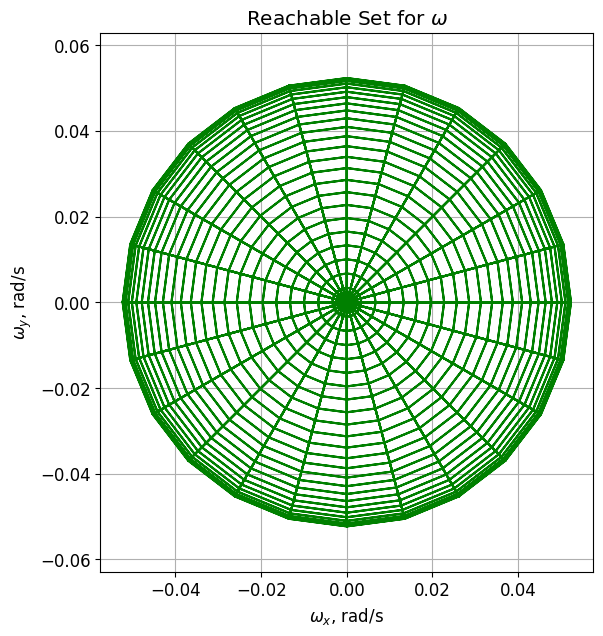

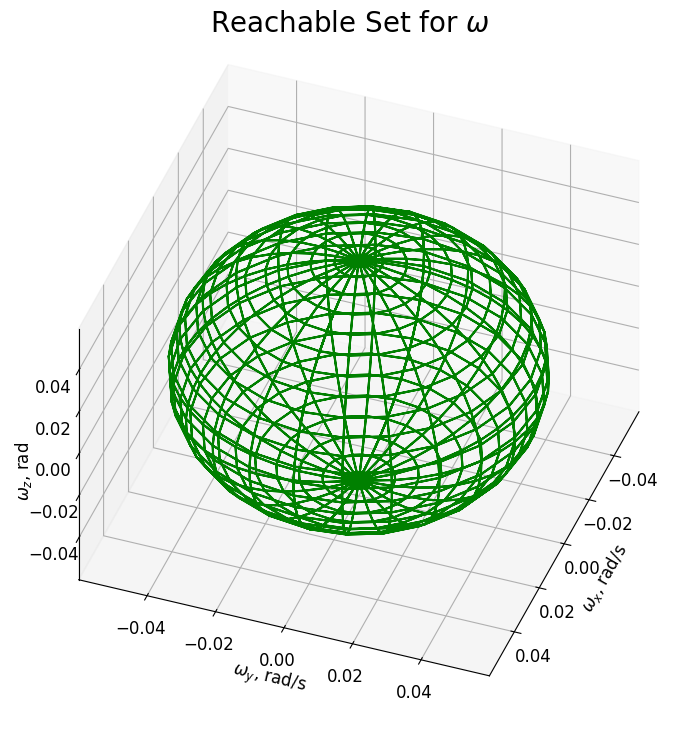

In [91]:
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 12})
ax1 = plt.subplot(121)
ax1.plot(inv_points[0, :], inv_points[1, :], 'g')
# ax.plot(pointscl[0, :], pointscl[1, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\omega_x$, rad/s')
ax1.set_ylabel('$\\omega_y$, rad/s')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
plt.title('Reachable Set for $\\omega$')


plt.figure(figsize=(14,7))
ax1 = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=20)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax1.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :],'g')
# ax.plot3D(pointscl[0, :], pointscl[1, :], pointscl[2, :],'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\omega_x$, rad/s')
ax1.set_ylabel('$\\omega_y$, rad/s')
ax1.set_zlabel('$\\omega_z$, rad')
ax1.set_title('Reachable Set for $\\omega$', fontsize=20)
# plt.subplots_adjust(left=9, right=10, top=0.5, bottom=0.08)
# plt.tight_layout()
plt.axis('auto')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [92]:
u_points = np.zeros((3,inv_points.shape[1]))
for i in range(inv_points.shape[1]):
    e = np.array([inv_points[0,i], inv_points[1,i], inv_points[2,i]])
    u_points[:,i] = B@K@e

Text(0.5, 0.92, 'Saturation Set of Control Inputs $\\dot{\\omega}$')

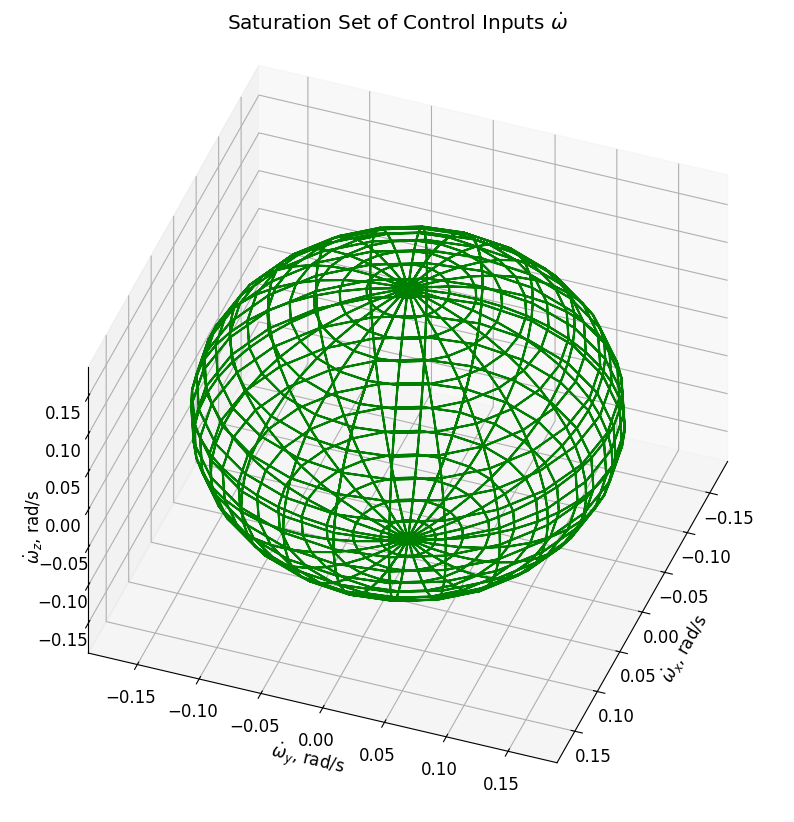

In [93]:
plt.figure(figsize=(10,12))
ax = plt.subplot(111, projection='3d', proj_type='ortho', elev=40, azim=20)
ax.plot3D(u_points[0, :], u_points[1, :], u_points[2, :],'g')
ax.set_xlabel('$\\dot{\\omega}_x$, rad/s', labelpad=5)
ax.set_ylabel('$\\dot{\\omega}_y$, rad/s')
ax.set_zlabel('$\\dot{\\omega}_z$, rad/s')
ax.set_title('Saturation Set of Control Inputs $\\dot{\\omega}$')

In [104]:
J = np.array([[0.02166666666666667, 0, 0], 
              [0, 0.02166666666666667, 0],
              [0, 0, 0.04000000000000001]])
M_points = np.zeros((3, u_points.shape[1]))
for i in range(u_points.shape[1]):
    omega_dot = np.array([u_points[0,i], u_points[1,i], u_points[2,i]])
    M_points[:,i] = J@omega_dot

Text(0.5, 0.92, 'Saturation Set of Moments')

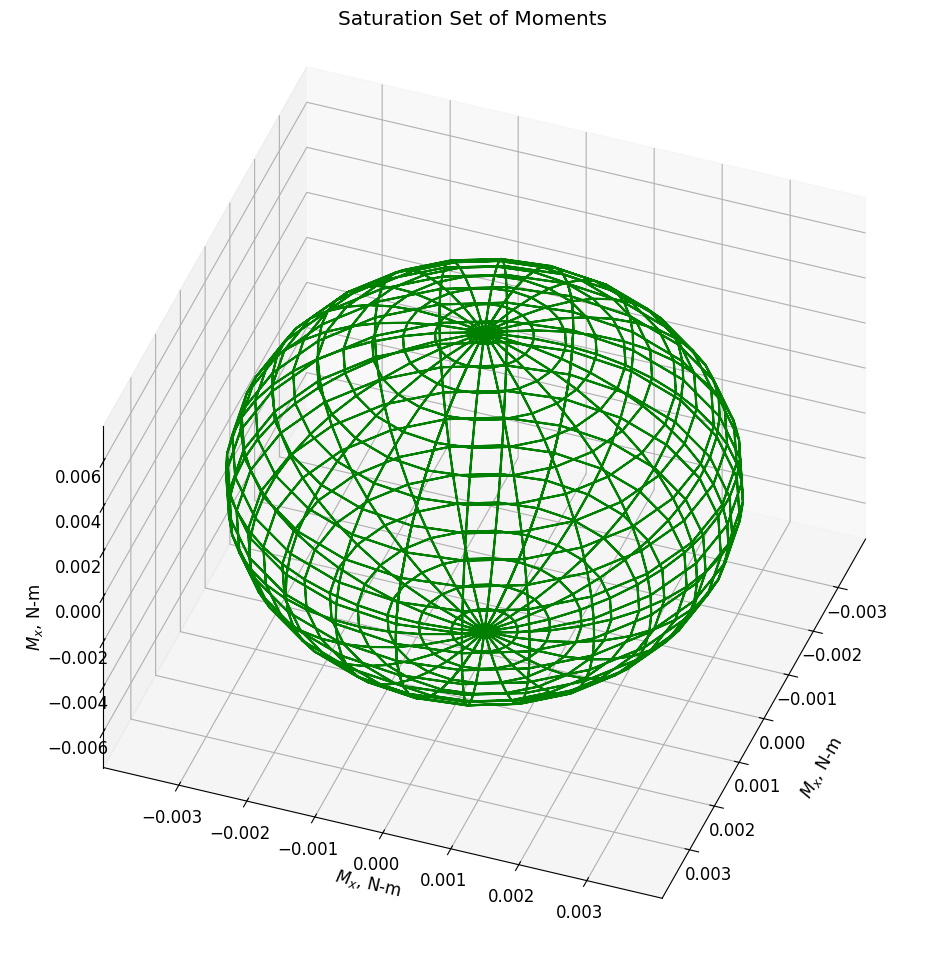

In [105]:
plt.figure(figsize=(14,12))
ax = plt.subplot(111, projection='3d', proj_type='ortho', elev=40, azim=20)
ax.plot3D(M_points[0, :], M_points[1, :], M_points[2, :],'g')
ax.set_xlabel('$M_x$, N-m', labelpad=15)
ax.set_ylabel('$M_x$, N-m')
ax.set_zlabel('$M_x$, N-m', labelpad=10)
ax.set_title('Saturation Set of Moments')

In [106]:
# solve LMI
sol_LMI = find_se23_invariant_set([0], [0], [9.8], [0], [0], [0])

0.4
optimal


In [107]:
# Initial condition
e = np.array([0,0,0,0,0,0,0,0,0]) # initial error in Lie group (nonlinear)

# transfer initial error to Lie algebra (linear)
e0 = ca.DM(SE23Dcm.vee(SE23Dcm.log(SE23Dcm.matrix(e))))
e0 = np.array([e0]).reshape(9,)
ebeta = e0.T@sol_LMI['P']@e0

# find invairant set points in Lie algebra (linear)
points, val = se23_invariant_set_points(sol_LMI, 20, 0, omegabound, ebeta)
points_theta, val = se23_invariant_set_points_theta(sol_LMI, 20, 0, omegabound, ebeta)
points_v, val = se23_invariant_set_points_theta(sol_LMI, 20, 0, w, ebeta)

In [108]:
# map invariant set points to Lie group (nonlinear)
inv_points = exp_map(points, points_theta)

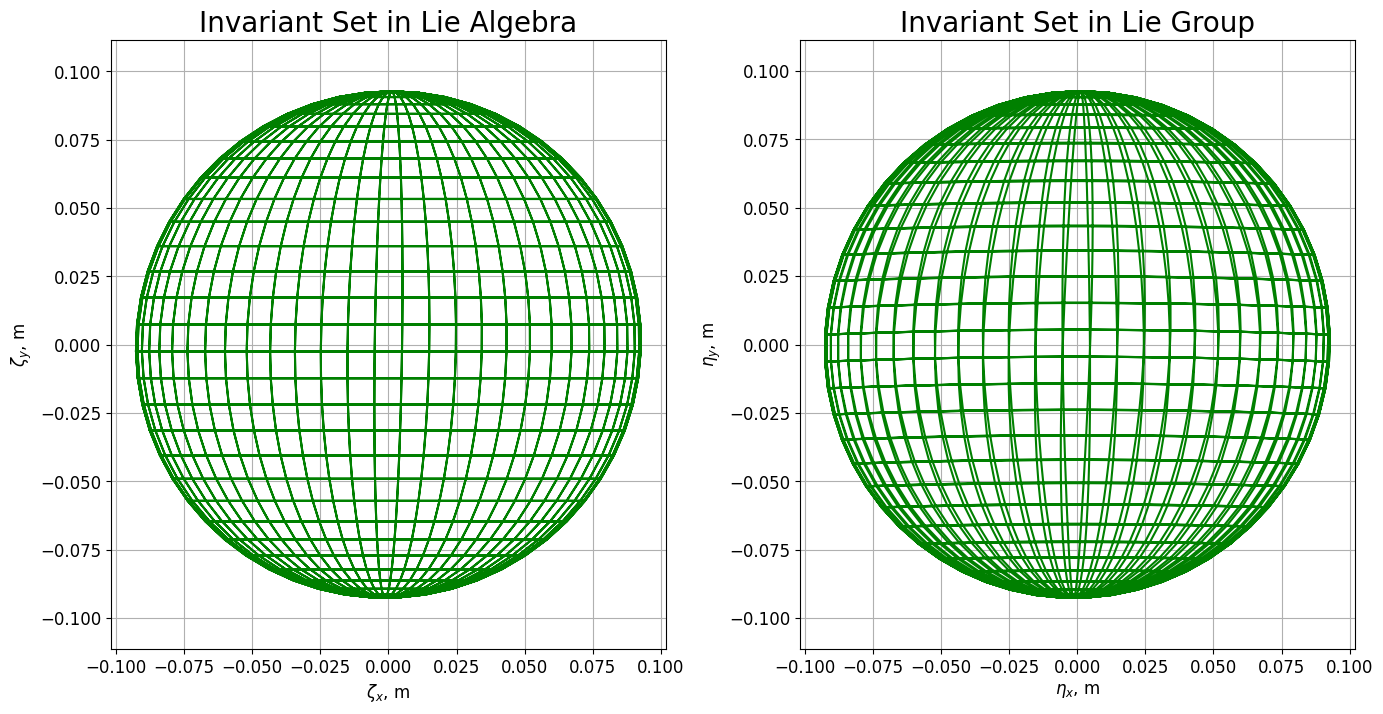

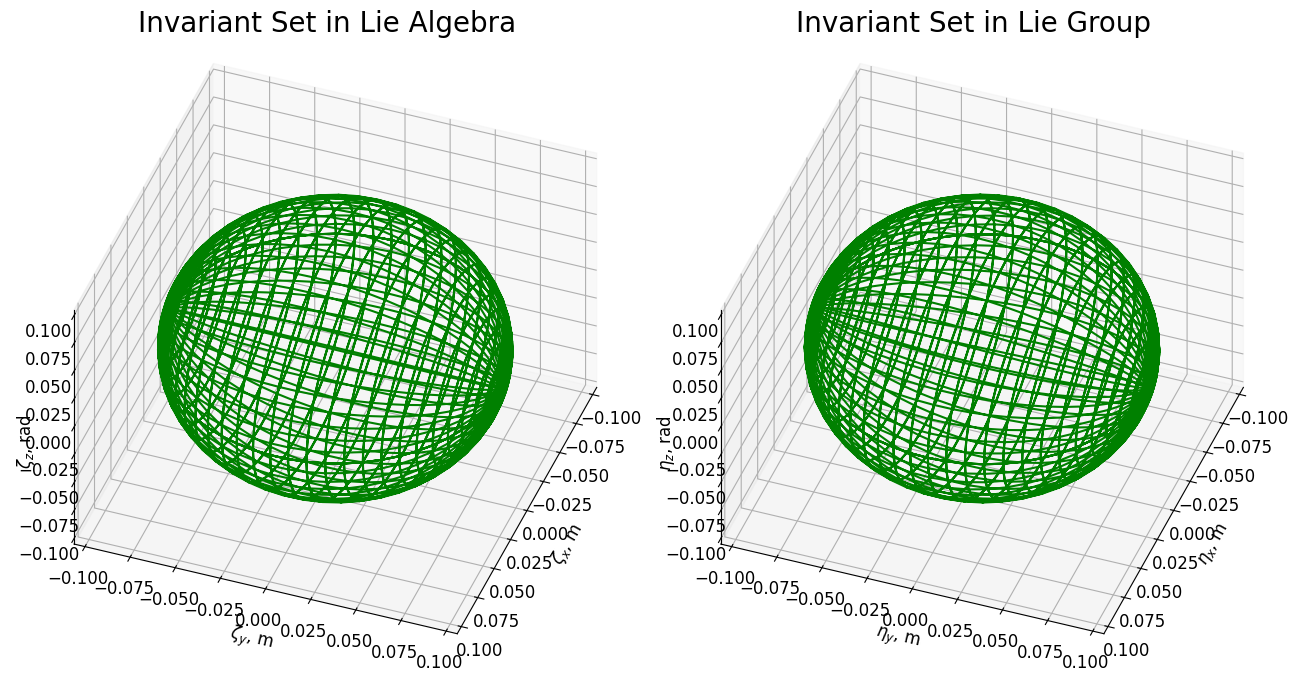

In [109]:
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 12})
ax1 = plt.subplot(121)
ax1.plot(points[0, :], points[1, :], 'g', label='with Dynamic Inversion')
# ax.plot(pointscl[0, :], pointscl[1, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\zeta_x$, m')
ax1.set_ylabel('$\\zeta_y$, m')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
# plt.legend(loc=1)
ax2 = plt.subplot(122)
ax2.plot(inv_points[0, :-1], inv_points[1, :-1], 'g', label='with Dynamic Inversion')
# ax2.plot(inv_pointscl[0, :-1], inv_pointscl[1, :-1], 'b', linewidth=0.5, label='without Dynamic Inversion')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
plt.grid(True)
# plt.legend(loc=1)
plt.axis('equal')
plt.tight_layout()
ax1.set_title('Invariant Set in Lie Algebra', fontsize=20)
ax2.set_title('Invariant Set in Lie Group', fontsize=20)
# plt.savefig('figures/Invariant_l.eps', format='eps', bbox_inches='tight')

plt.figure(figsize=(14,7))
ax1 = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=20)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax1.plot3D(points[0, :], points[1, :], points[2, :],'g', label='with Dynamic Inversion')
# ax.plot3D(pointscl[0, :], pointscl[1, :], pointscl[2, :],'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\zeta_x$, m')
ax1.set_ylabel('$\\zeta_y$, m')
ax1.set_zlabel('$\\zeta_z$, rad', labelpad=1)
ax1.set_title('Invariant Set in Lie Algebra', fontsize=20)
# plt.subplots_adjust(left=9, right=10, top=0.5, bottom=0.08)
# plt.tight_layout()
plt.axis('auto')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.legend(loc=1)
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=20)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :], 'g', label='with Dynamic Inversion')
# ax2.plot3D(inv_pointscl[0, :], inv_pointscl[1, :], inv_pointscl[2, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_x$, m')
ax2.set_ylabel('$\\eta_y$, m')
ax2.set_zlabel('$\\eta_z$, rad')
ax2.set_title('Invariant Set in Lie Group', fontsize=20)
plt.axis('auto')
plt.subplots_adjust(left=0.45, right=1, top=0.5, bottom=0.08)
# plt.legend(loc=1)
plt.tight_layout()
# plt.savefig('figures/Invariant3d_l.eps', format='eps', bbox_inches='tight')

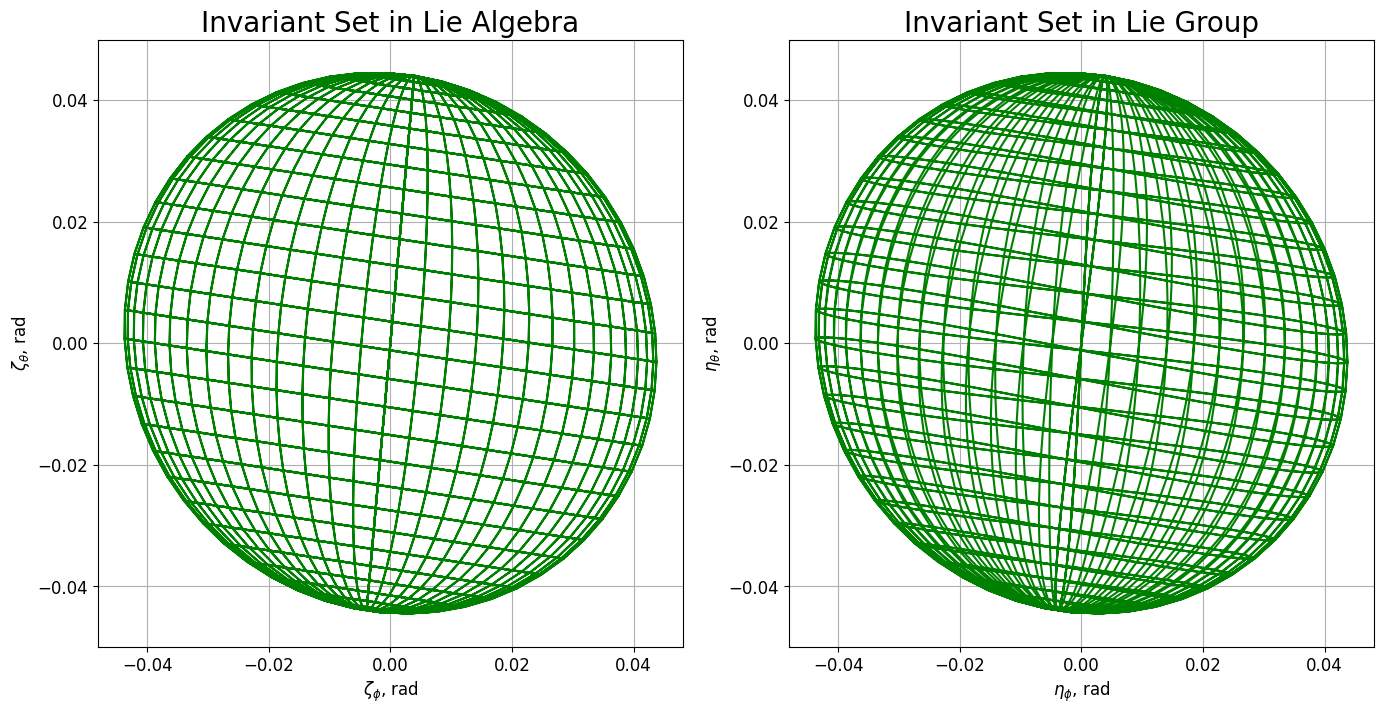

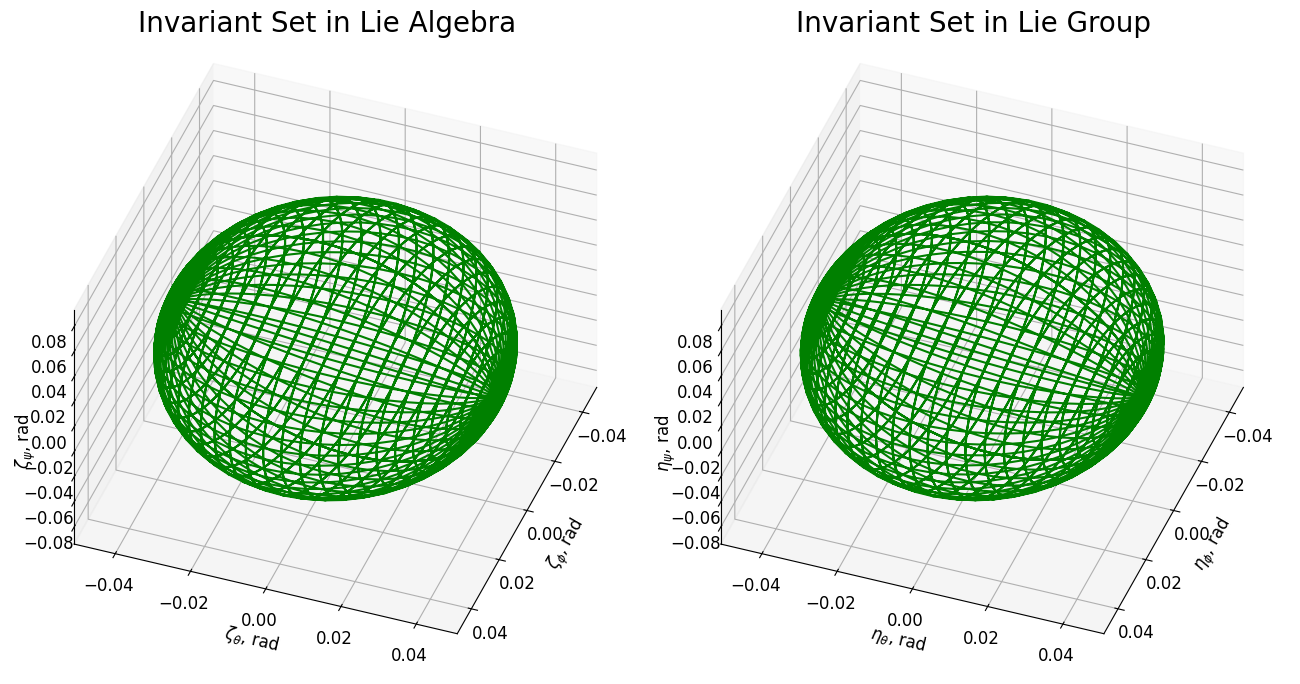

In [121]:
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 12})
ax1 = plt.subplot(121)
ax1.plot(points_theta[0, :], points_theta[1, :], 'g', label='with Dynamic Inversion')
# ax.plot(pointscl[0, :], pointscl[1, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\zeta_\\phi$, rad')
ax1.set_ylabel('$\\zeta_\\theta$, rad')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
# plt.legend(loc=1)
ax2 = plt.subplot(122)
ax2.plot(inv_points[3, :-1], inv_points[4, :-1], 'g', label='with Dynamic Inversion')
# ax2.plot(inv_pointscl[0, :-1], inv_pointscl[1, :-1], 'b', linewidth=0.5, label='without Dynamic Inversion')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$\\eta_\\phi$, rad')
ax2.set_ylabel('$\\eta_\\theta$, rad')
plt.grid(True)
# plt.legend(loc=1)
plt.axis('equal')
plt.tight_layout()
ax1.set_title('Invariant Set in Lie Algebra', fontsize=20)
ax2.set_title('Invariant Set in Lie Group', fontsize=20)
# plt.savefig('figures/Invariant_l.eps', format='eps', bbox_inches='tight')

plt.figure(figsize=(14,7))
ax1 = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=20)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax1.plot3D(points_theta[0, :], points_theta[1, :], points_theta[2, :],'g', label='with Dynamic Inversion')
# ax.plot3D(pointscl[0, :], pointscl[1, :], pointscl[2, :],'b', linewidth=0.5, label='without Dynamic Inversion')
ax1.set_xlabel('$\\zeta_\\phi$, rad')
ax1.set_ylabel('$\\zeta_\\theta$, rad')
ax1.set_zlabel('$\\zeta_\\psi$, rad', labelpad=1)
ax1.set_title('Invariant Set in Lie Algebra', fontsize=20)
# plt.subplots_adjust(left=9, right=10, top=0.5, bottom=0.08)
# plt.tight_layout()
plt.axis('auto')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.legend(loc=1)
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=20)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_points[3, :], inv_points[4, :], inv_points[5, :], 'g', label='with Dynamic Inversion')
# ax2.plot3D(inv_pointscl[0, :], inv_pointscl[1, :], inv_pointscl[2, :], 'b', linewidth=0.5, label='without Dynamic Inversion')
# ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('$\\eta_\\phi$, rad')
ax2.set_ylabel('$\\eta_\\theta$, rad')
ax2.set_zlabel('$\\eta_\\psi$, rad')
ax2.set_title('Invariant Set in Lie Group', fontsize=20)
plt.axis('auto')
plt.subplots_adjust(left=0.45, right=1, top=0.5, bottom=0.08)
# plt.legend(loc=1)
plt.tight_layout()
# plt.savefig('figures/Invariant3d_l.eps', format='eps', bbox_inches='tight')

In [110]:
B_zeta, K_zeta, _, _ = se23_solve_control(0, 0, 9.8, 0, 0, 0)
u_zeta_points = np.zeros((9,points.shape[1]))
for i in range(points.shape[1]):
    e = SE23Dcm.wedge(np.array([points[0,i], points[1,i], points[2,i], points_v[0,i], points_v[1,i], points_v[2,i], points_theta[0,i], points_theta[1,i], points_theta[2,i]]))
    u_zeta_points[:,i] = np.array(ca.DM(B_zeta@K_zeta@SE23Dcm.vee(e))).reshape(9,) #np.array(ca.DM(control_law(B,K,e))).reshape(9,)

Text(0.5, 0.92, 'Invariant Set of Control Inputs for Angular')

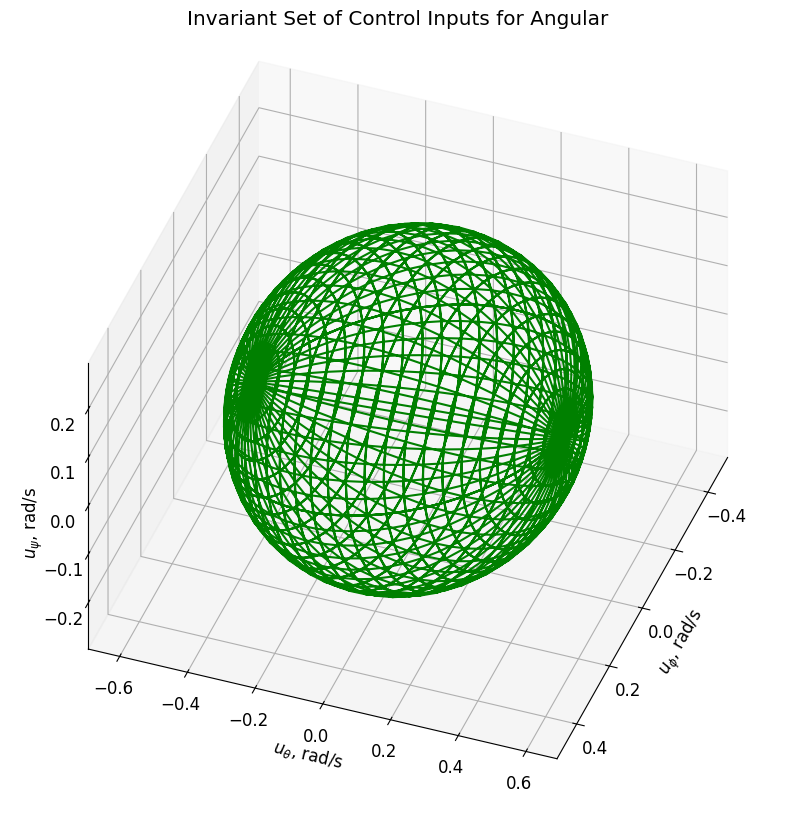

In [111]:
plt.figure(figsize=(10,12))
ax = plt.subplot(111, projection='3d', proj_type='ortho', elev=40, azim=20)
ax.plot3D(u_zeta_points[6, :], u_zeta_points[7, :], u_zeta_points[8, :],'g', label='with Dynamic Inversion')
ax.set_xlabel('$u_{\\phi}$, rad/s')
ax.set_ylabel('$u_{\\theta}$, rad/s')
ax.set_zlabel('$u_{\\psi}$, rad/s')
ax.set_title('Invariant Set of Control Inputs for Angular')

In [112]:
J = np.array([[0.02166666666666667, 0, 0], 
              [0, 0.02166666666666667, 0],
              [0, 0, 0.04000000000000001]])
M_points = np.zeros((3, u_points.shape[1]))
for i in range(u_points.shape[1]):
    omega_dot = np.array([u_points[0,i], u_points[1,i], u_points[2,i]])
    omega = np.array([u_zeta_points[6,i], u_zeta_points[7,i], u_zeta_points[8,i]])
    M_points[:,i] = J@omega_dot + np.cross(omega, J@omega)

Text(0.5, 0.92, 'Saturation Set of Moments')

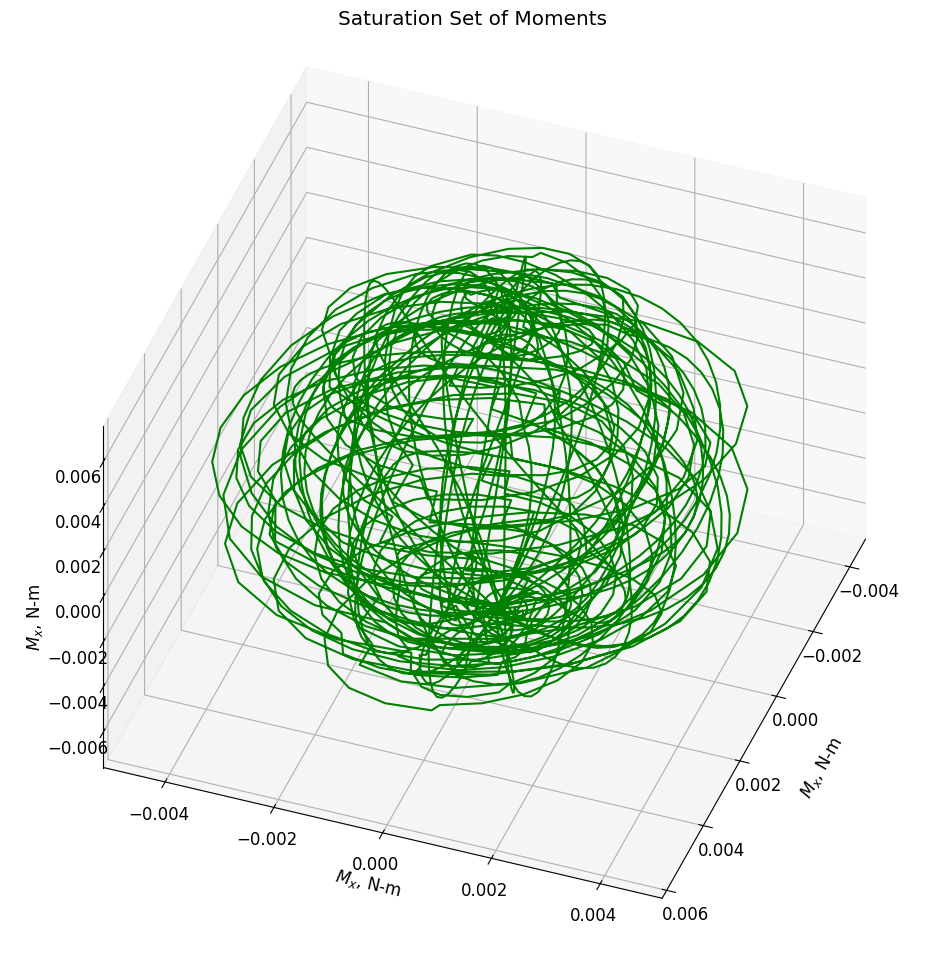

In [113]:
plt.figure(figsize=(14,12))
ax = plt.subplot(111, projection='3d', proj_type='ortho', elev=40, azim=20)
ax.plot3D(M_points[0, :], M_points[1, :], M_points[2, :],'g')
ax.set_xlabel('$M_x$, N-m', labelpad=15)
ax.set_ylabel('$M_x$, N-m')
ax.set_zlabel('$M_x$, N-m', labelpad=10)
ax.set_title('Saturation Set of Moments')